# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# Seleção dos dados

In [2]:
file_path = r'.\dataset_cotton_fruit.xlsx'
fs_df = pd.read_excel(file_path)

In [3]:
params = ['SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
fs_params = fs_df[params].dropna()

fs_vars = fs_df.iloc[:, 7:].columns.to_list()
dados_wl = fs_df[fs_vars].dropna()

wl = np.arange(350, 2501, 1)
dados_wl = fs_df[fs_vars]

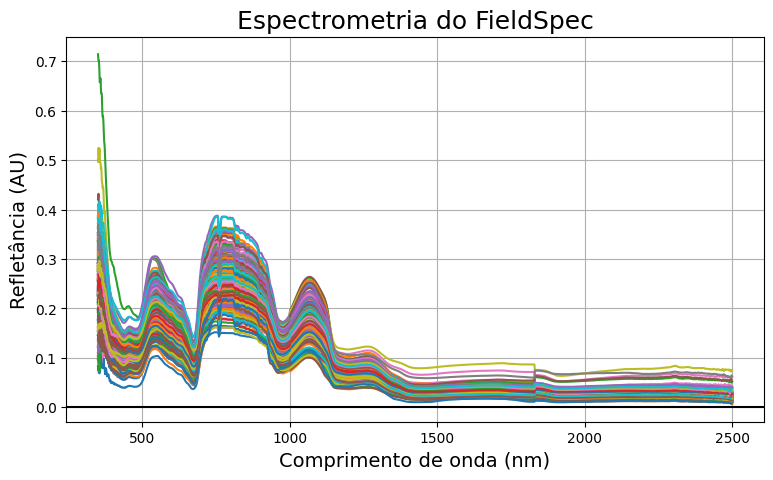

In [4]:
plt.figure(figsize=(9,5))
plt.plot(wl, dados_wl.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Espectrometria do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()


# Pré-processamentos

### Savitzky-Golay

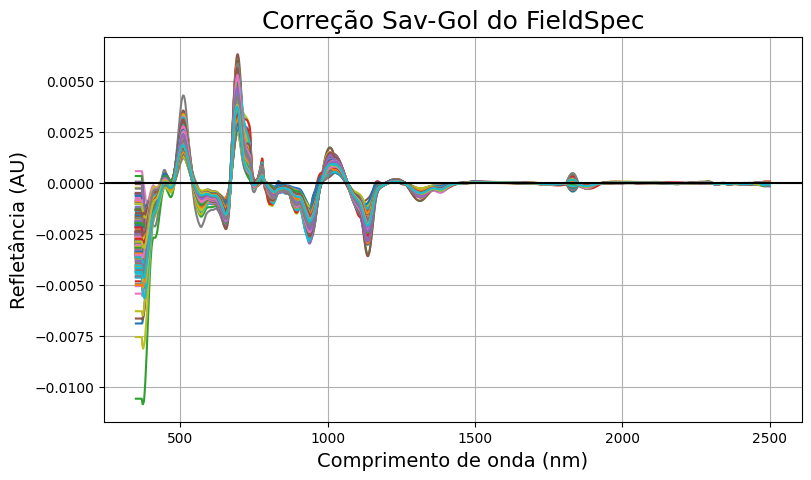

Dataset exported successfully to Excel.


In [5]:
sav_gol = savgol_filter(dados_wl, 41, polyorder=1, deriv=1) 
plt.figure(figsize=(9,5))
plt.plot(wl, sav_gol.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção Sav-Gol do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

df_savgol = pd.DataFrame(sav_gol)
filename = 'data_savgol_ordem_1.xlsx'
df_savgol.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

### MSC

In [6]:
def apply_msc(df):
    mean_spectrum = df.mean(axis=0)
    corrected_spectra = []
    
    for i in range(df.shape[0]):
        spectrum = df.iloc[i, :]
        slope, intercept = np.polyfit(mean_spectrum, spectrum, 1)
        corrected_spectrum = (spectrum - intercept) / slope
        corrected_spectra.append(corrected_spectrum)
    
    corrected_df = pd.DataFrame(corrected_spectra, columns=df.columns)
    
    return corrected_df

df_msc = apply_msc(dados_wl)

df = pd.DataFrame(df_msc)
filename = 'data_msc.xlsx'
df.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.


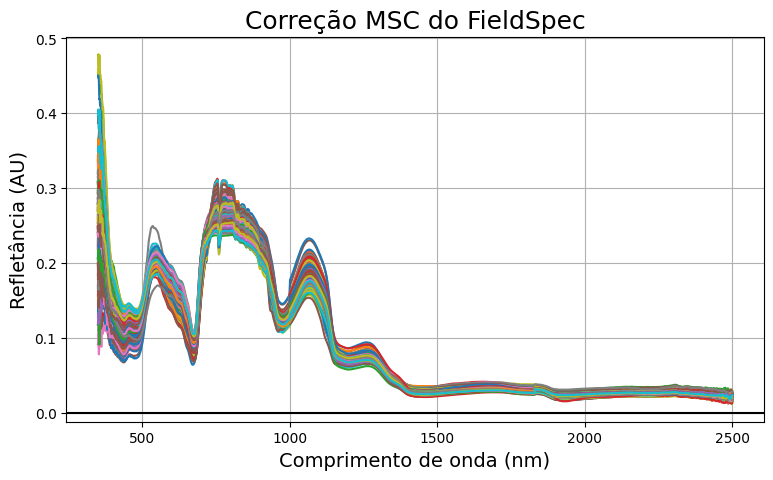

In [7]:
plt.figure(figsize=(9, 5))
plt.plot(wl, df_msc.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção MSC do FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

### SNV

In [8]:
def snv(input_data):
    mean = np.mean(input_data, axis=1, keepdims=True)
    std_dev = np.std(input_data, axis=1, keepdims=True)
    snv_data = (input_data - mean) / std_dev
    return snv_data

df_snv = snv(dados_wl.values)
df_snv = pd.DataFrame(df_snv, columns=wl)

filename = "data_snv.xlsx"
df_snv.to_excel(filename, index=False)
print("Dataset exported successfully to Excel.")

Dataset exported successfully to Excel.


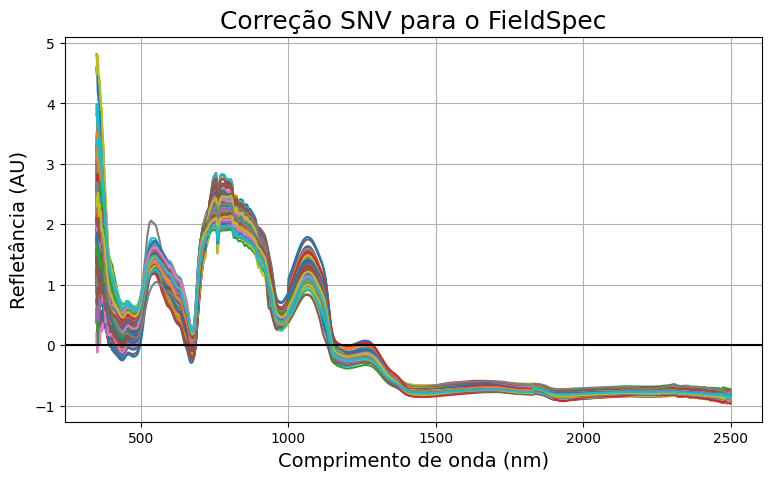

In [9]:
plt.figure(figsize=(9, 5))
plt.plot(wl, df_snv.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção SNV para o FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

In [10]:
import numpy as np
from sklearn.decomposition import PCA

def osc(X, y, n_components=250):
    """
    Aplica o OSC para remover variações ortogonais aos dados espectrais X
    considerando a variável de resposta y.

    X: Matriz de dados espectrais (amostras x variáveis)
    y: Variável de resposta (amostras)
    n_components: Número de componentes ortogonais a serem removidos
    """
    X_centered = X - X.mean(axis=0)
    y_centered = y - y.mean(axis=0)
    
    # Calcular a projeção da variável de resposta
    pca_y = PCA(n_components=n_components)
    T = pca_y.fit_transform(y_centered.reshape(-1, 1))
    
    # Calcular os loadings dos componentes ortogonais
    P = np.dot(np.dot(X_centered.T, T), np.linalg.inv(np.dot(T.T, T)))
    
    # Remover variação ortogonal
    X_osc = X_centered - np.dot(T, P.T)
    
    return X_osc

# Exemplo de uso
X = dados_wl.values
y = fs_df['SST'].values  # Variável de resposta simulada


X_osc = osc(X, y, n_components=1)
X_osc


array([[-0.12008556, -0.109991  , -0.12322132, ..., -0.00106901,
        -0.0011276 , -0.00240102],
       [-0.01112998, -0.01677825, -0.0073115 , ...,  0.00655911,
         0.00699908,  0.00603731],
       [-0.07999207, -0.08835335, -0.09110526, ..., -0.00062756,
         0.00030427,  0.00337073],
       ...,
       [ 0.04140384,  0.04702962,  0.06003289, ...,  0.0122426 ,
         0.01098094,  0.0072912 ],
       [ 0.0044004 ,  0.01252645,  0.01440419, ...,  0.01174863,
         0.01184802,  0.01069385],
       [ 0.10780569,  0.10090777,  0.10216546, ...,  0.0134203 ,
         0.01428756,  0.01516444]])

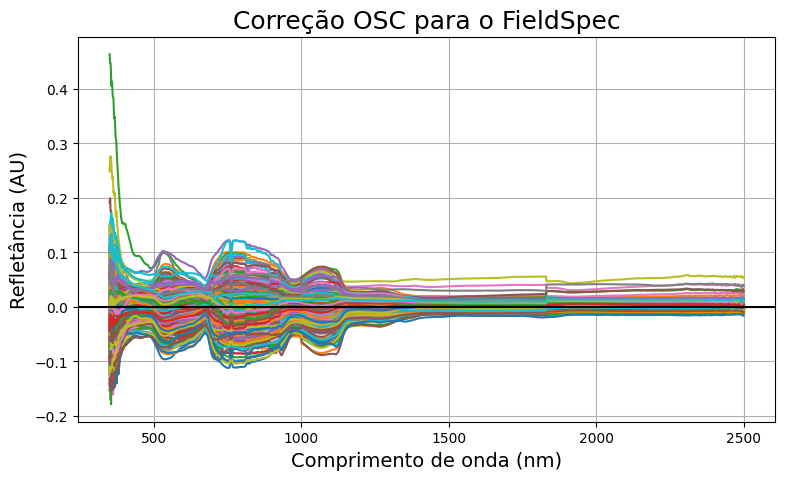

In [11]:
plt.figure(figsize=(9, 5))
plt.plot(wl, X_osc.T)
plt.xlabel("Comprimento de onda (nm)", size=14)
plt.ylabel("Refletância (AU)", size=14)
plt.title("Correção OSC para o FieldSpec", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)
plt.grid("on")
plt.show()

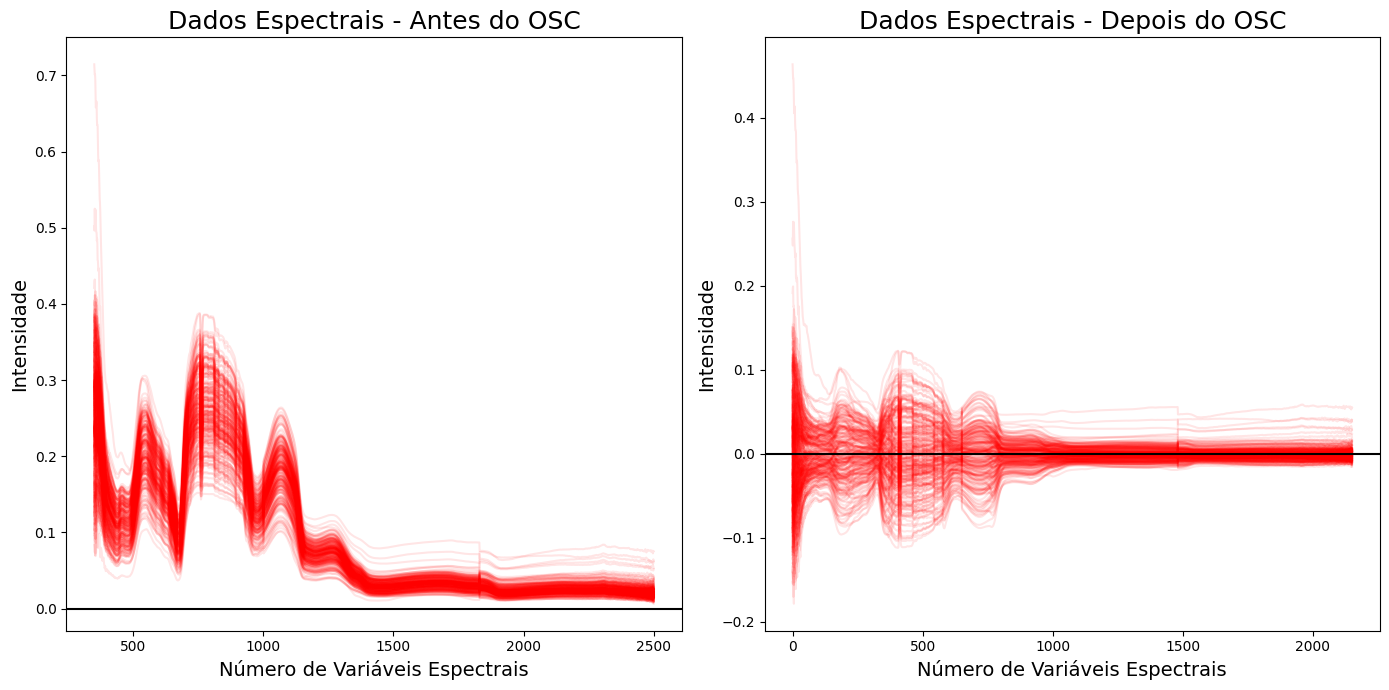

In [12]:
# Plotando os dados
plt.figure(figsize=(14, 7))

# Antes do OSC
plt.subplot(1, 2, 1)
plt.plot(dados_wl.T, color='red', alpha=0.1)
plt.xlabel("Número de Variáveis Espectrais", size=14)
plt.ylabel("Intensidade", size=14)
plt.title("Dados Espectrais - Antes do OSC", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)

# Depois do OSC
plt.subplot(1, 2, 2)
plt.plot(X_osc.T, color='red', alpha=0.1)
plt.xlabel("Número de Variáveis Espectrais", size=14)
plt.ylabel("Intensidade", size=14)
plt.title("Dados Espectrais - Depois do OSC", size=18)
plt.axhline(y=0, color='k', linewidth=1.5)

plt.tight_layout()
plt.show()